<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">pyGROWAT2D</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);"><b style=color:red;>GRO</b>und<b style=color:red;>WAT</b>er</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
<td><img style="height: 150px;" src="images/pyGROWAT2D.png"></td>
</tr>
</table>

----
# `pyGROWAT2D`

GROundWATer2D, a program package for  flow in porous rocks.

# Finite differences 
## Advection equation in 2D
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

----
In this notebook, we solve a simple **transient advection equation** in two dimensions,
using different numerical methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The general advection-diffusion-reacton equation reads:
$$\fbox{$
\frac{\partial c}{\partial t}
= - v \cdot \nabla c
+ \nabla D \nabla c
+ R
$}$$
with
$c$ [mol/m$^3$] concentration,
$x,y,z$ [m] position,
$t$ [s] time,
$v$ [m/s] the velocity, 
$D$ [m$^2$/s] diffusion, 
$R$ [mol/m$^3$/s] reaction,
$\nabla$ [1/m] Nabla operator.

The term on the left-hand side is the temporal change of $c$,
the terms on the right-hand sides are
- advection
- diffusion
- reaction

----
## Advection

We start defining the transient advection equation in 2D for the concentration $c(x,y,t)$:
$$
\fbox{$
\frac{\partial c(x,y,t)}{\partial t} + v_x \frac{\partial c(x,y,t)}{\partial x} + v_y \frac{\partial c(x,y,t)}{\partial y} = 0
$}
$$

The transient advection equation is a **hyperbolic partial differential equation**, which has a unique
solution for the **initial condition**:
$$
c(x,y,t=0) = c_0(x,y,0)
$$

----
## Initial condition

We define the `Gaussian` 2D function with $x$ and $y$ [m] as coordinates,
means $\mu_x,\mu_y$ and standard deviations $\sigma_x,\sigma_y$
as initial condition:
$$
c(x,y) = e^{-\frac{(x-\mu_x)^2}{2\sigma_x^2}} e^{-\frac{(y-\mu_y)^2}{2\sigma_y^2}}
$$
which is a solution of the transient advection equation.

In [2]:
def pulse2D(x,y,mu=[0,0],sigma=[1,1]):
    """
    Initial 2D pulse function centered at mu=(mu_x,mu_y) 
    and having standard with sigma (sigma_x,sigma_y)
    """
    f = np.zeros([x.shape[0],y.shape[0]])
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            f[i,j] = np.exp(-(x[i]-mu[0])**2/(2*sigma[0])**2) #
            f[i,j] *= np.exp(-(y[j]-mu[1])**2/(2*sigma[1])**2)
    return f

In [3]:
xstep = 101
ystep = 51
x,dx = np.linspace(-2,10,xstep,retstep=True)   # m
y,dy = np.linspace(-2,2,ystep,retstep=True)   # m
X,Y = np.meshgrid(x,y,indexing='ij')
print(dx,dy)

0.12 0.08


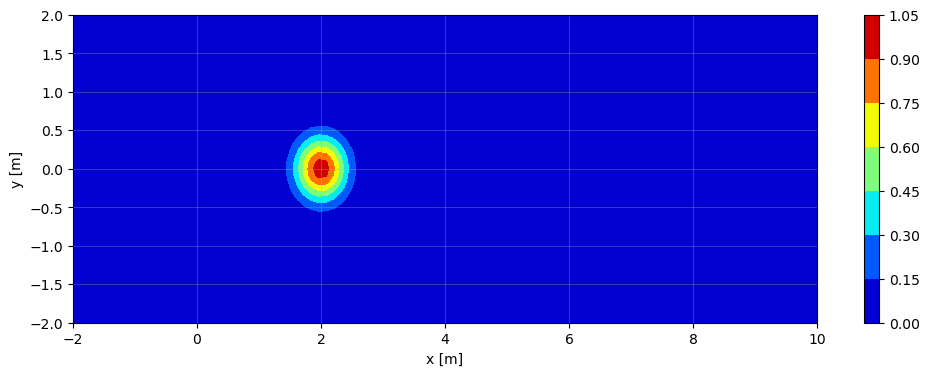

In [4]:
c0 = pulse2D(x,y,mu=[2,0],sigma=[0.2,0.2])

plt.figure(figsize=(12,4))
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.grid(alpha=0.3)
bar1=plt.contourf(X,Y,c0,cmap='jet')
label1=plt.colorbar(bar1)

----
## Numerical solution methods

Next, we derive several numerical methods, which can be used to solve the transient advection equation.
We first need to assign the temporal and spatial time steps, $\Delta t$ [s] and $\Delta x$ [m], 
and the velocity $c$ [m/s]:

Thus we have discretised both spatial and temporal variables:
$$
\begin{array}{rcl}
t_n &=& t_0 + n \Delta t, \quad n=0,N \\
x_i &=& x_0 + i \Delta x, \quad i=0,I \\
y_j &=& y_0 + j \Delta y, \quad j=0,J
\end{array}
$$

The **advective Courant-Friedrich-Levi criterion**, also called *advective Courant number*, is defined as
$$
Co^a = \frac{v_x \Delta t}{\Delta x} + \frac{v_y \Delta t}{\Delta y}
$$
It defines the stability of the numerical solutions. Explicit solutions are stable
for $Co^a <1$.

We solve for the time increment:
$$
\Delta t^a < \frac{1}{\frac{v_x}{\Delta x} + \frac{v_y}{\Delta y}}
$$

For a given velocity $v$, the time steps can  be defined:

In [10]:
vx,vy = 0.5,0.0 # m/s
if (vx==0 and vy==0):
    dtAdv = np.nan
else:
    dtAdv = 1 / (vx/dx + vy/dy)
               
print ('Courant time step: ',dtAdv)
safety = 0.2
dtAdv *= safety
print ('Courant time step with safety margin: ',dtAdv)

Courant time step:  0.24
Courant time step with safety margin:  0.048


In [11]:
timeStart = 0.
timeEnd   = 5.
timeStep  = dtAdv
timeWrite = 1.

----
## FTCS scheme (forward time centered space)

Our first scheme is called `FTCS`, forward time, centered space, thus the derivatives in the
transient advection equations are replaced by **forward differences in time** and 
**central differences is space**:
$$
\frac{c_{{i,j}}^{n+1}-c_{{i,j}}^{n}}{\Delta t}
=
-v_x \frac{c_{{i+1,j}}^{n}-c_{{i-1,j}}^{n}}{2 \Delta x}
-v_y \frac{c_{{i,j+1}}^{n}-c_{{i,j-1}}^{n}}{2 \Delta y}
$$
or solved for the next time step
$$
c_{{i,j}}^{n+1}
=
c_{{i,j}}^{n} 
- \frac{v_x \Delta t}{2 \Delta x} \left( c_{{i+1,j}}^{n}-c_{{i-1,j}}^{n} \right)
- \frac{v_y \Delta t}{2 \Delta y} \left( c_{{i,j+1}}^{n}-c_{{i,j-1}}^{n} \right)
$$

<img src="images/PDE_FTCS.jpg" style="height:5cm;">

We implement the FTCS method:

In [12]:
def FD_Advection1D(c,dx,dy,dt,vx,vy):
    """
    2D advection operator
    FTCS forward time centered space
    """
    nx = c.shape[0]
    ny = c.shape[1]
    cold = c
    for i in range(nx):
        for j in range(ny):
            if (i != 0 and i != nx-1 and j != 0 and j != ny-1):
                c[i,j] = cold[i,j] - vx*dt/(2*dx) * (cold[i+1,j]-cold[i-1,j]) - vy*dt/(2*dy) * (cold[i,j+1]-cold[i,j-1])
            else:
                c[i,j] = cold[i,j]
    return c

In [13]:
# initial conditions
time = timeStart
c    = pulse2D(x,y,mu=[2,0],sigma=[0.2,0.2])
c0  = np.copy(c)

# time loop
while (time < timeEnd):
    time += timeStep
    c = FD_Advection1D(c,dx,dy,timeStep,vx,vy)

/var/folders/g1/lkn34rdd3158l1w_kz2l0dt80000gn/T/ipykernel_3619/2830234226.py:8: UserWarning: The following kwargs were not used by contour: 'lw', 'ls', 'color'
  plt.contour(X,Y,c0,lw=1,ls='dashed',color=(0.5,0.5,0.5),alpha=0.5)


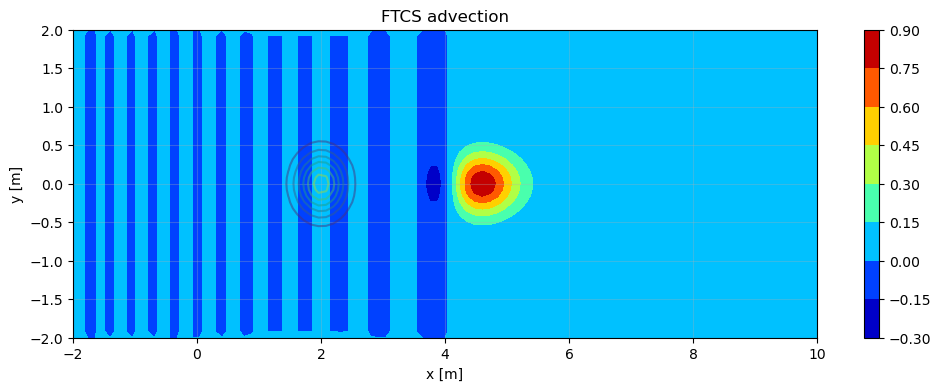

In [14]:
plt.figure(figsize=(12,4))
plt.title('FTCS advection')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.grid(alpha=0.3)
bar1=plt.contourf(X,Y,c,cmap='jet')
label1=plt.colorbar(bar1)
plt.contour(X,Y,c0,lw=1,ls='dashed',color=(0.5,0.5,0.5),alpha=0.5)

Try this example with the **rectangular pulse** of `pulse()` to observe how instable this method can become ...

----